In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter

In [3]:
# important paths and file names

BIKE_DATA_PATH = "/media/mircea/CEF1-30A0/data/"
MAIN_DATA_FILE_NAME = "_speed_acc.txt"

TRIP_SAVE_LOCATION = "/home/mircea/.bike-sys/"
# TRIP_SAVE_LOCATION = "./test/"
CSV_HEAD_DATA_FILE = "detection time micros\n" 

DEFAULT_TRIP_NAME = "trip.txt"

In [4]:
# useful constants

# conversions
MM_TO_KM = 1000000
MM_TO_M = 1000
KMPH_TO_MPS = 1000 / 3600
BIKE_WHEEL_DIAMETER_MM = 700
BIKE_WHEEL_PERIMETER_MM = BIKE_WHEEL_DIAMETER_MM * np.pi

MMPUS_TO_KMPH = 3_600


In [5]:
# a couple of functions to make stat printing easier


def getVelocityList(momentMicrosList):
    tripLength = len(momentMicrosList)

    velocityList = np.zeros(tripLength)
        # velocity is distance over speed
    velocityList[0] = BIKE_WHEEL_PERIMETER_MM / momentMicrosList[0] * MMPUS_TO_KMPH
    for i in range(1, tripLength):
        velocityList[i] = BIKE_WHEEL_PERIMETER_MM / (momentMicrosList[i] - momentMicrosList[i-1]) * MMPUS_TO_KMPH

    return velocityList

def getTripData(tripFiles):
    tripDataNames = ["maxSpeed", "averageSpeed", "longestTripLength", "totalDistance", "averageTripDistance", "distanceList"]
    tripData = {}

    if(len(tripFiles) == 0):
        for dataName in tripDataNames:
            if(dataName == "distanceList"):
                tripData[dataName] = [0]
            else:
                tripData[dataName] = 0
        return tripData
    
    for dataName in tripDataNames:
        if dataName != "distanceList":
            tripData[dataName] = 0
        else:
            tripData["distanceList"] = []

    for tripFileName in tripFiles:
        tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
        momentMicrosList = tripCsv['detection time micros']
        
        tripLength = len(momentMicrosList)
        tripData["distanceList"].append(tripLength)
        tripData["totalDistance"] += tripLength
        
        velocityList = getVelocityList(momentMicrosList)
        tripMaxSpeed = max(velocityList)
        tripData["averageSpeed"] += sum(velocityList)/len(velocityList)

        if tripMaxSpeed > tripData["maxSpeed"]:
            tripData["maxSpeed"] = tripMaxSpeed
        if tripLength > tripData["longestTripLength"]:
            tripData["longestTripLength"] = tripLength
    
    tripData["averageSpeed"] /= len(tripFiles)
    tripData["longestTripLength"] = tripData["longestTripLength"] * BIKE_WHEEL_PERIMETER_MM / MM_TO_KM
    tripData["totalDistance"] = tripData["totalDistance"] * BIKE_WHEEL_PERIMETER_MM / MM_TO_KM
    tripData["averageTripDistance"] = tripData["totalDistance"] / len(tripFiles)
    for distanceIdx in range(0, len(tripData["distanceList"])):
        tripData["distanceList"][distanceIdx] = tripData["distanceList"][distanceIdx] * BIKE_WHEEL_PERIMETER_MM / MM_TO_KM

    return tripData

DISTANCES_TO_PRINT = 10
def printTripData(tripData):
    print("fastest speed:\t" + str(tripData["maxSpeed"]) + " KM/H")
    print("average speed:\t" + str(round(tripData["averageSpeed"], 2)) + " KM/H")
    print()
    print("longest trip:\t" + str(round(tripData["longestTripLength"], 2)) + " KM")
    print("total distance:\t" + str(round(tripData["totalDistance"], 2)) + " KM")
    print("avg distance:\t" + str(round(tripData["averageTripDistance"], 2)) + " KM")
    print("latest dists:\t", end="")
    
    distancesToPrint = DISTANCES_TO_PRINT
    if len(tripData["distanceList"]) < DISTANCES_TO_PRINT:
        distancesToPrint = len(tripData["distanceList"])

    for idx in range(len(tripData["distanceList"]) - 1, len(tripData["distanceList"]) - distancesToPrint - 1, -1):
        print(round(tripData["distanceList"][idx], 2), end=", ")



In [6]:
#   * split the collected data into trips (data is stored in equally sized chunks)
#   * delete everything on the sd card to make room for new data
#   * print facts about the new trips

MIN_LINES_IN_FILE = 12 # more or less 50 meters (don't count trips shorter than this)

allFiles = os.listdir(BIKE_DATA_PATH)
dataFiles = [file for file in allFiles if MAIN_DATA_FILE_NAME in file]

def sortMethod(fileName):
    number = fileName.split('_')[0]
    return number

dataFiles.sort(key = sortMethod)
print(dataFiles)

numberOfSavedTrips = 0

def findNumberOfSavedTrips():
    tripFiles = os.listdir(TRIP_SAVE_LOCATION)
    return len(tripFiles)

tripIdx = findNumberOfSavedTrips() - 1 # i do  ++ every time i find the csv header
currentTripName = str(tripIdx) + "_" + DEFAULT_TRIP_NAME

fileLines = 0
inFirstFile = True

newFileNames = []

for dataFileName in dataFiles:
    with open(BIKE_DATA_PATH + dataFileName, 'r') as dataFile:
        for line in dataFile:
            if line == CSV_HEAD_DATA_FILE:
                if fileLines <= MIN_LINES_IN_FILE and not(inFirstFile):
                    os.remove(TRIP_SAVE_LOCATION + currentTripName)
                else:
                    tripIdx += 1    
                    currentTripName = str(tripIdx) + "_" + DEFAULT_TRIP_NAME
                    inFirstFile = False
                    newFileNames.append(currentTripName)
                fileLines = 0
            
            with open(TRIP_SAVE_LOCATION + currentTripName, 'a') as newTripFile:
                newTripFile.write(line)
            
            fileLines += 1

if fileLines <= MIN_LINES_IN_FILE and not inFirstFile:
    os.remove(TRIP_SAVE_LOCATION + currentTripName)

print("created:")
print(newFileNames)

if len(dataFiles) > 0:          
    print("facts about the new data:")
    printTripData(getTripData(newFileNames))



['0_speed_acc.txt', '1_speed_acc.txt', '2_speed_acc.txt', '3_speed_acc.txt', '4_speed_acc.txt', '5_speed_acc.txt']
created:
['1_trip.txt', '2_trip.txt', '3_trip.txt', '4_trip.txt', '5_trip.txt']
facts about the new data:
fastest speed:	40.39169946605516 KM/H
average speed:	19.93 KM/H

longest trip:	4.39 KM
total distance:	14.62 KM
avg distance:	2.92 KM
latest dists:	2.72, 0.2, 3.2, 4.1, 4.39, 

In [7]:
# run to delete SD contents

if len(dataFiles) > 0:
    for dataFileName in dataFiles:
        os.remove(BIKE_DATA_PATH + dataFileName)

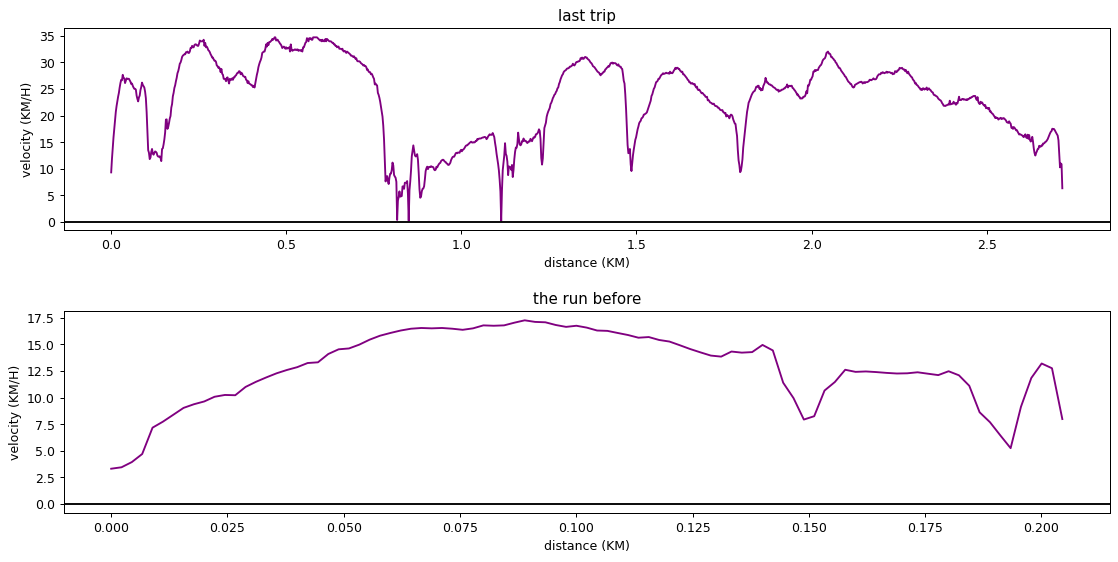

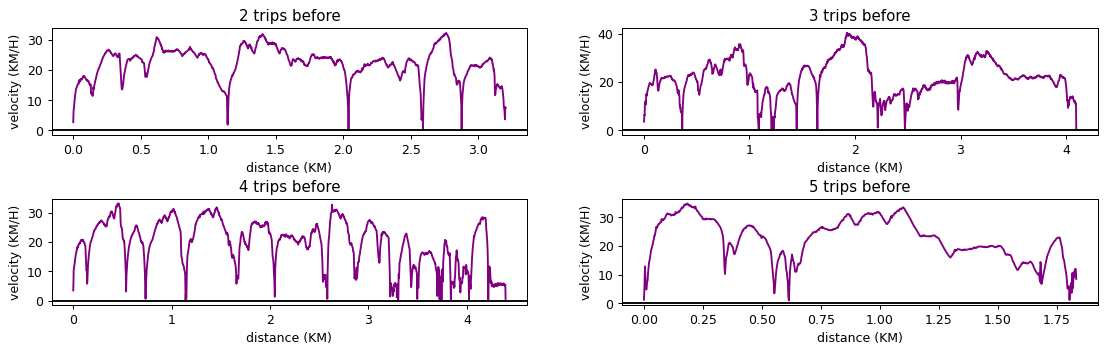

In [8]:
# run this to plot:
#   * the latest two trips speed evolution (big picture)
#   * 4 other trips speed evolution before them

FIGURE_COLS = 1
FIGURE_ROWS = 2

PAST_TRIPS_TO_SHOW = 4

TRIP_TO_SHOW = 2

tripFiles = os.listdir(TRIP_SAVE_LOCATION)
tripFiles.sort(reverse=True)


# big plot of the past two trips followed by small plots of 5 previous trips 
figure(figsize=(15, 7), dpi=90)
tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFiles[0])
velocityList = getVelocityList(tripCsv['detection time micros'])
velocityListLen = len(velocityList)


distanceList = np.linspace(0, velocityListLen, velocityListLen)
distanceList = [distMarker * (BIKE_WHEEL_PERIMETER_MM / MM_TO_KM) for distMarker in distanceList]

plt.subplot(FIGURE_ROWS, FIGURE_COLS, 1)
plt.plot(distanceList, velocityList, color="purple")
plt.xlabel("distance (KM)")
plt.ylabel("velocity (KM/H)")
plt.title("last trip")
plt.axhline(0, color="black")

tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFiles[1])
velocityList = getVelocityList(tripCsv['detection time micros'])
velocityListLen = len(velocityList)
distanceList = np.linspace(0, velocityListLen, velocityListLen)
distanceList = [distMarker * (BIKE_WHEEL_PERIMETER_MM / MM_TO_KM) for distMarker in distanceList]

plt.subplot(FIGURE_ROWS, FIGURE_COLS, 2)
plt.plot(distanceList, velocityList, color="purple")
plt.xlabel("distance (KM)")
plt.ylabel("velocity (KM/H)")
plt.title("the run before")
plt.axhline(0, color="black")

plt.subplots_adjust(hspace=0.4)
plt.show()


################# smaller plots
SUB_FIGURE_COLS = 2
SUB_FIGURE_ROWS = 2

figure(figsize=(15, 4), dpi=90)

for i in range(0, PAST_TRIPS_TO_SHOW):
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFiles[i + 2])
    velocityList = getVelocityList(tripCsv['detection time micros'])
    velocityListLen = len(velocityList)
    
    distanceList = np.linspace(0, velocityListLen, velocityListLen)
    distanceList = [distMarker * (BIKE_WHEEL_PERIMETER_MM / MM_TO_KM) for distMarker in distanceList]

    plt.subplot(SUB_FIGURE_ROWS, SUB_FIGURE_COLS, i + 1)
    plt.plot(distanceList, velocityList, color="purple")
    plt.xlabel("distance (KM)")
    plt.ylabel("velocity (KM/H)")
    plt.title(str(i + 2) + " trips before")
    plt.axhline(0, color="black")


plt.subplots_adjust(hspace=0.6)
plt.show()

	All time stats:
fastest speed:	40.39169946605516 KM/H
average speed:	20.37 KM/H

longest trip:	4.39 KM
total distance:	16.45 KM
avg distance:	2.74 KM
latest dists:	1.83, 4.39, 4.1, 3.2, 0.2, 2.72, 

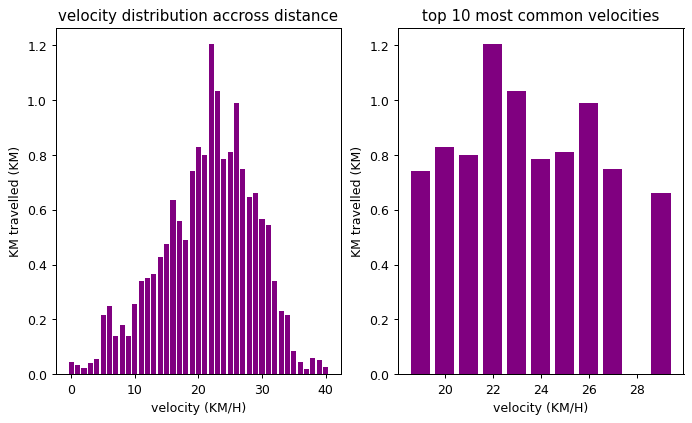

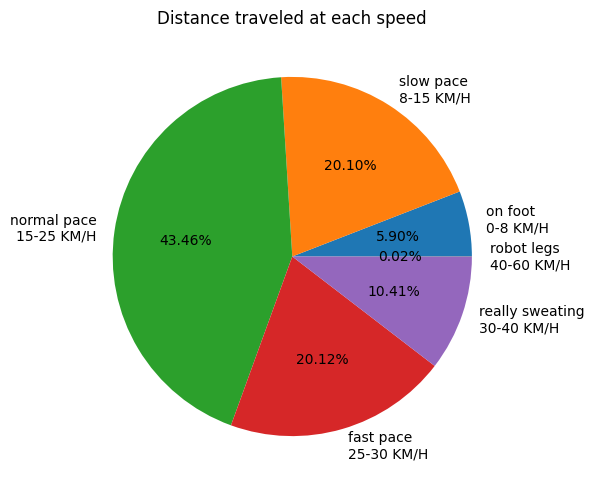

In [11]:
# show stats on all trips

# show most commons speeds (top 5?)
# do a pie chart of like 5 bins

print("\tAll time stats:")
tripFiles = os.listdir(TRIP_SAVE_LOCATION)
tripFiles.sort(reverse=True)

# tripFiles = os.listdir(TRIP_SAVE_LOCATION)

printTripData(getTripData(tripFiles))
# print("\n\n\tLast week stats")

velocityBins = [0, 8, 15, 25, 30, 40, 60]
binsLables = ["on foot\n0-8 KM/H", "slow pace\n8-15 KM/H", "normal pace\n15-25 KM/H", "fast pace\n25-30 KM/H", "really sweating\n30-40 KM/H", "robot legs\n40-60 KM/H"]

averageHistogram = np.zeros(len(binsLables))
speedCounter = Counter()

for tripFileName in tripFiles:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    velocityList = getVelocityList(tripCsv['detection time micros'])
    
    histogram, trash = np.histogram(velocityList,velocityBins)
    histogram = histogram/len(velocityList)
    averageHistogram += histogram
    speedCounter.update([round(speed, 0) for speed in velocityList])

figure(figsize=(9,5), dpi=90)
plt.subplot(1, 2, 1)
mostCommonSpeeds = np.array(speedCounter.most_common(len(speedCounter)))
plt.bar(mostCommonSpeeds[:, 0], mostCommonSpeeds[:, 1] * BIKE_WHEEL_PERIMETER_MM / MM_TO_KM, width=0.8, color="purple")
plt.title("velocity distribution accross distance")
plt.xlabel("velocity (KM/H)")
plt.ylabel("KM travelled (KM)")

plt.subplot(1, 2, 2)
mostCommonSpeeds = np.array(speedCounter.most_common(10))
plt.bar(mostCommonSpeeds[:, 0], mostCommonSpeeds[:, 1] * BIKE_WHEEL_PERIMETER_MM / MM_TO_KM, width=0.8, color="purple")
plt.title("top 10 most common velocities")
plt.xlabel("velocity (KM/H)")
plt.ylabel("KM travelled (KM)")
plt.show()

averageHistogram = averageHistogram / len(tripFiles)

figure(figsize=(6, 6), dpi=100)
plt.title("Distance traveled at each speed")
patches, labels, autotexts = plt.pie(averageHistogram, labels=binsLables, autopct='%1.2f%%')

# labels[0]._y += 0.1
# labels[4]._y -= 0.1

plt.tight_layout()


Text(0.5, 1.0, 'trip corelations')

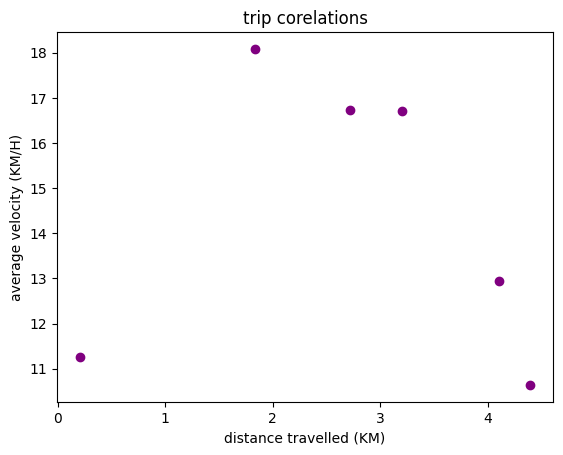

In [12]:
# run this to see corelations between trips
tripFiles = os.listdir(TRIP_SAVE_LOCATION)
tripFiles.sort()

averageTripSpeed = []
tripDistance = []

for tripFileName in tripFiles:
    tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFileName)
    velocityList = getVelocityList(tripCsv['detection time micros'])
    timeList = tripCsv['detection time micros']
    timeListLen = len(timeList)

    tripDistance.append(timeListLen)
    averageTripSpeed.append(timeListLen * BIKE_WHEEL_PERIMETER_MM / timeList[timeListLen - 1] * MMPUS_TO_KMPH)

tripDistance = [dist * BIKE_WHEEL_PERIMETER_MM / MM_TO_KM for dist in tripDistance]

plt.scatter(tripDistance, averageTripSpeed, color="purple")
plt.ylabel("average velocity (KM/H)")
plt.xlabel("distance travelled (KM)")
plt.title("trip corelations")

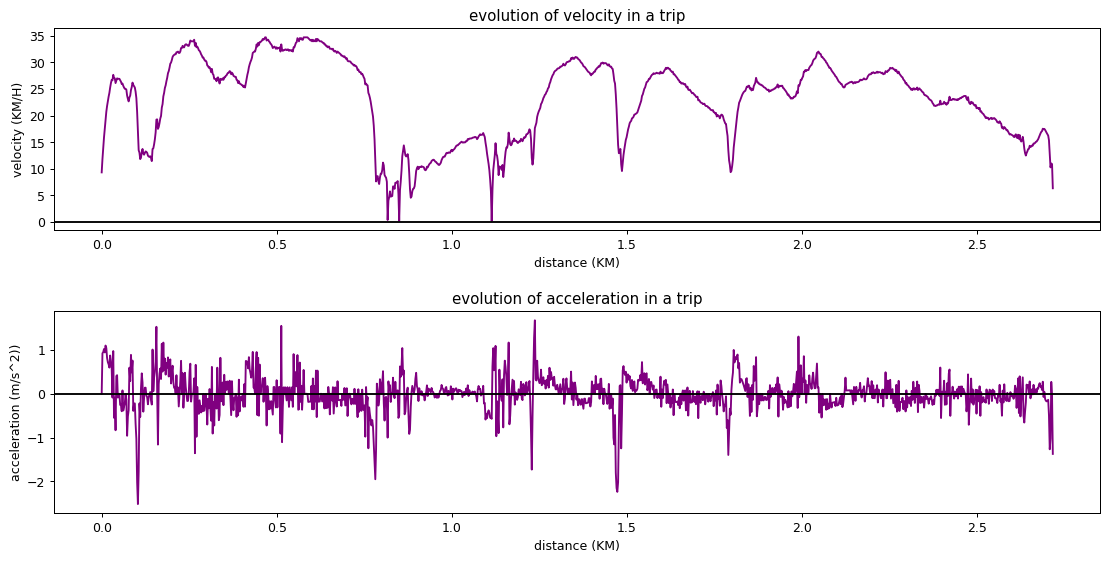

Total acceleration: -0.0006652343114374044


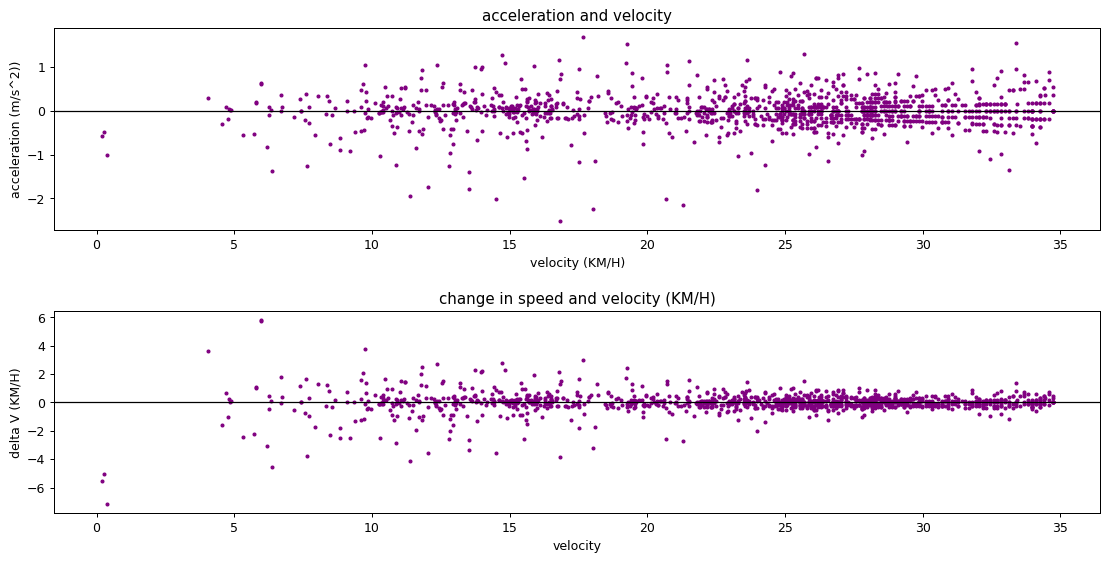

-0.0006652343114374044


In [15]:
# run this to plot:
#   interesting things about the latest trip

# problematic trips: 
    # 1
    # 2
    # 3 
    # 4-> really really bad

TRIP_TO_SHOW = 0

tripFiles = os.listdir(TRIP_SAVE_LOCATION)
tripFiles.sort(reverse=True)

tripCsv = pd.read_csv(TRIP_SAVE_LOCATION + tripFiles[TRIP_TO_SHOW])
velocityList = getVelocityList(tripCsv['detection time micros'])
velocityListLen = len(velocityList)

deltaVelList = np.zeros(velocityListLen)
for i in range(1, velocityListLen):
    deltaVelList[i] = velocityList[i] - velocityList[i-1]

accList = [accVal * KMPH_TO_MPS/(2 * BIKE_WHEEL_PERIMETER_MM / MM_TO_M) for accVal in deltaVelList]
# accList = [accVal / 36 * 1000  / 36 / 2 / 7 / 2 / np.pi for accVal in accList]

accList[0] = 0 
for idx in range(1, len(accList)):
    accList[idx] *= (velocityList[idx] + velocityList[idx - 1]) * KMPH_TO_MPS
    
    if(accList[idx] > 2):
        print(velocityList[idx])
distanceList = np.linspace(0, len(accList), len(accList))
distanceList = [distMarker * (BIKE_WHEEL_PERIMETER_MM / MM_TO_KM) for distMarker in distanceList]


FIGURE_COLS = 1
FIGURE_ROWS = 2

# plt.subplot(FIGURE_ROWS, FIGURE_COLS, 1)
figure(figsize=(15, 7), dpi=90)
plt.subplot(FIGURE_ROWS, FIGURE_COLS, 1)
plt.plot(distanceList, velocityList, color="purple")
plt.xlabel("distance (KM)")
plt.ylabel("velocity (KM/H)")
plt.axhline(0, color="black")
plt.title("evolution of velocity in a trip")

plt.subplot(FIGURE_ROWS, FIGURE_COLS, 2)
plt.plot(distanceList, accList, color="purple")
plt.ylabel("acceleration (m/s^2))")
plt.xlabel("distance (KM)")
plt.title("evolution of acceleration in a trip")
plt.axhline(0, color="black")
# plt.axhline(5, color="red")
# plt.axhline(2.5, color="orange")

plt.subplots_adjust(hspace=0.4)
plt.show()


figure(figsize=(15, 7), dpi=90)
plt.subplot(FIGURE_ROWS, FIGURE_COLS, 1)
plt.scatter(velocityList, accList, s=5, color="purple")
plt.xlabel("velocity (KM/H)")
plt.ylabel("acceleration (m/s^2))")
plt.title("acceleration and velocity")
accAverage = sum(accList)/len(accList)
print("Total acceleration:", accAverage)
plt.axhline(y=accAverage, color='black', linewidth=1)

plt.subplot(FIGURE_ROWS, FIGURE_COLS, 2)
plt.scatter(velocityList, deltaVelList, s=5, color="purple")
plt.xlabel("velocity")
plt.ylabel("delta V (KM/H)")
plt.title("change in speed and velocity (KM/H)")
plt.axhline(y=0, color='black', linewidth=1)

plt.subplots_adjust(hspace=0.4)
plt.show()

# uncomment to plot acceleration and velocity graph again, but wider
# make every point a slightly different hue
figure(figsize=(15, 7), dpi=900)
plt.scatter(velocityList, accList, s=0.5, color="purple")
plt.xlabel("velocity (KM/H)")
plt.ylabel("acceleration (m/s^2))")
plt.title("the most interesting plot")
accAverage = sum(accList)/len(accList)
print(accAverage)
plt.axhline(y=accAverage, color='black', linewidth=1)
plt.show()
